# <center style='color:green'>Conditional Generative Adversarial Network (`Conditional_GAN`) using PyTorch - Example with `FashionMNIST` dataset</center>

# 1. Import required libraries

In [1]:
import torch
print('PyTorch version:', torch.__version__)
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
print('Torchvision version:', torchvision.__version__)
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from torchinfo import summary

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117


# 2. Define the device

In [2]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

GPU name: NVIDIA RTX A5000 

Device is: cuda 

Total number of GPUs: 1


# 3. Load `FashionMNIST` dataset

In [3]:
transform = transforms.Compose([transforms.Resize((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

In [4]:
fmnist_dataset = datasets.FashionMNIST(root='./data_src', train=True, download=True, transform=transform)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:18<00:00, 1448422.50it/s]


Extracting ./data_src/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data_src/FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 104905.49it/s]


Extracting ./data_src/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data_src/FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:09<00:00, 453116.93it/s]


Extracting ./data_src/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data_src/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 7371893.82it/s]

Extracting ./data_src/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_src/FashionMNIST/raw



In [5]:
print('Length of the FashionMNIST (training) dataset:', len(fmnist_dataset))

Length of the FashionMNIST (training) dataset: 60000


In [6]:
print('Shape of the FashionMNIST (training) dataset:', fmnist_dataset.data.shape)

Shape of the FashionMNIST (training) dataset: torch.Size([60000, 28, 28])


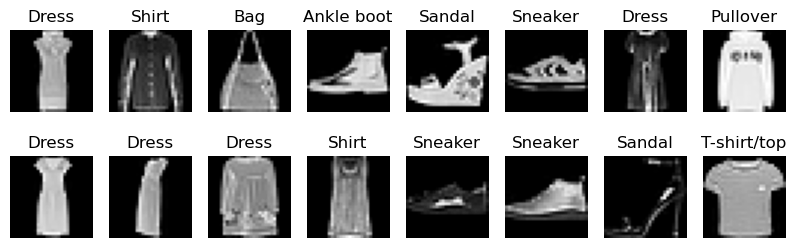

In [7]:
# show 16 randomly selected samples from the FashionMNIST (training) dataset

fig, axis = plt.subplots(nrows=2, ncols=8, figsize=(10, 3))

for ax, _ in zip(axis.ravel(), range(16)):
    inx = np.random.randint(len(fmnist_dataset))
    ax.imshow(fmnist_dataset.data[inx], cmap='gray')
    ax.set_title(fmnist_dataset.classes[fmnist_dataset.targets[inx]], fontsize=12)
    ax.axis(False);

# 4. Define dataloader

In [8]:
data_loader = DataLoader(fmnist_dataset, batch_size=256, shuffle=True, drop_last=True)

In [9]:
print('Length of the dataloader (training):', len(data_loader))

Length of the dataloader (training): 234


# 5. Create `DISCRIMINATOR` architecture

In [10]:
class DISCRIMINATOR(nn.Module):
    def __init__(self, emb_size=20):
        super(DISCRIMINATOR, self).__init__()
        
        self.emb_size = emb_size
        self.embedding = nn.Embedding(num_embeddings=10, embedding_dim=self.emb_size)
        
        self.discrim1 = nn.Sequential()
        self.discrim1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1))
        self.discrim1.add_module('lrel1', nn.LeakyReLU(negative_slope=0.2))
        self.discrim1.add_module('conv2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1))
        self.discrim1.add_module('bnor2', nn.BatchNorm2d(num_features=128))
        self.discrim1.add_module('lrel2', nn.LeakyReLU(negative_slope=0.2))
        self.discrim1.add_module('conv3', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1))
        self.discrim1.add_module('bnor3', nn.BatchNorm2d(num_features=256))
        self.discrim1.add_module('lrel3', nn.LeakyReLU(negative_slope=0.2))
        self.discrim1.add_module('conv4', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1))
        self.discrim1.add_module('bnor4', nn.BatchNorm2d(num_features=512))
        self.discrim1.add_module('lrel4', nn.LeakyReLU(negative_slope=0.2))
        self.discrim1.add_module('conv5', nn.Conv2d(in_channels=512, out_channels=64, kernel_size=4, stride=2, padding=1))
        self.discrim1.add_module('bnor5', nn.BatchNorm2d(num_features=64))
        self.discrim1.add_module('lrel5', nn.LeakyReLU(negative_slope=0.2))
        self.discrim1.add_module('flat5', nn.Flatten())
        
        self.discrim2 = nn.Sequential()
        self.discrim2.add_module('linr1', nn.Linear(in_features=256+self.emb_size, out_features=100))
        self.discrim2.add_module('lrel1', nn.LeakyReLU(negative_slope=0.2))
        self.discrim2.add_module('linr2', nn.Linear(in_features=100, out_features=1))
        self.discrim2.add_module('sgmd2', nn.Sigmoid())
        
    def forward(self, x, labels):
        x = self.discrim1(x)
        y = self.embedding(labels)
        z = torch.cat([x, y], dim=1)
        out = self.discrim2(z)
        return out

# 6. Visualize `DISCRIMINATOR` architecture

In [11]:
summary(DISCRIMINATOR(), input_size=[(256, 1, 64, 64), (256,)], dtypes=[torch.float, torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
DISCRIMINATOR                            [256, 1]                  --
├─Sequential: 1-1                        [256, 256]                --
│    └─Conv2d: 2-1                       [256, 64, 32, 32]         1,088
│    └─LeakyReLU: 2-2                    [256, 64, 32, 32]         --
│    └─Conv2d: 2-3                       [256, 128, 16, 16]        131,200
│    └─BatchNorm2d: 2-4                  [256, 128, 16, 16]        256
│    └─LeakyReLU: 2-5                    [256, 128, 16, 16]        --
│    └─Conv2d: 2-6                       [256, 256, 8, 8]          524,544
│    └─BatchNorm2d: 2-7                  [256, 256, 8, 8]          512
│    └─LeakyReLU: 2-8                    [256, 256, 8, 8]          --
│    └─Conv2d: 2-9                       [256, 512, 4, 4]          2,097,664
│    └─BatchNorm2d: 2-10                 [256, 512, 4, 4]          1,024
│    └─LeakyReLU: 2-11                   [256, 512, 4, 4]   

# 7. Create `GENERATOR` architecture

In [12]:
class GENERATOR(nn.Module):
    def __init__(self, emb_size=20):
        super(GENERATOR, self).__init__()
        
        self.emb_size = 20
        self.embedding = nn.Embedding(num_embeddings=10, embedding_dim=self.emb_size)
        
        self.generator = nn.Sequential()
        self.generator.add_module('tcon1', nn.ConvTranspose2d(in_channels=128+self.emb_size, out_channels=1024, kernel_size=4))
        self.generator.add_module('relu1', nn.ReLU())
        self.generator.add_module('tcon2', nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2,
                                                              padding=1))
        self.generator.add_module('bnor2', nn.BatchNorm2d(num_features=512))
        self.generator.add_module('relu2', nn.ReLU())
        self.generator.add_module('tcon3', nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2,
                                                              padding=1))
        self.generator.add_module('bnor3', nn.BatchNorm2d(num_features=256))
        self.generator.add_module('relu3', nn.ReLU())
        self.generator.add_module('tcon4', nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2,
                                                              padding=1))
        self.generator.add_module('bnor4', nn.BatchNorm2d(num_features=128))
        self.generator.add_module('relu4', nn.ReLU())
        self.generator.add_module('tcon5', nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=4, stride=2,
                                                              padding=1))
        self.generator.add_module('tanh5', nn.Tanh())
        
    def forward(self, x, labels):
        y = self.embedding(labels).view(len(labels), self.emb_size, 1, 1)
        z = torch.cat([x, y], dim=1)
        out = self.generator(z)
        return out

# 8. Visualize `GENERATOR` architecture

In [13]:
summary(GENERATOR(), input_size=[(256, 128, 1, 1), (256,)], dtypes=[torch.float, torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
GENERATOR                                [256, 1, 64, 64]          --
├─Embedding: 1-1                         [256, 20]                 200
├─Sequential: 1-2                        [256, 1, 64, 64]          --
│    └─ConvTranspose2d: 2-1              [256, 1024, 4, 4]         2,425,856
│    └─ReLU: 2-2                         [256, 1024, 4, 4]         --
│    └─ConvTranspose2d: 2-3              [256, 512, 8, 8]          8,389,120
│    └─BatchNorm2d: 2-4                  [256, 512, 8, 8]          1,024
│    └─ReLU: 2-5                         [256, 512, 8, 8]          --
│    └─ConvTranspose2d: 2-6              [256, 256, 16, 16]        2,097,408
│    └─BatchNorm2d: 2-7                  [256, 256, 16, 16]        512
│    └─ReLU: 2-8                         [256, 256, 16, 16]        --
│    └─ConvTranspose2d: 2-9              [256, 128, 32, 32]        524,416
│    └─BatchNorm2d: 2-10                 [256, 128, 32

# 9. Custom function to generate `random noise` 

In [14]:
def random_noise(batch_size):
    noise = torch.randn(batch_size, 128, 1, 1)
    return noise

# 10. Custom function to train the `discriminator`

In [15]:
def discriminator_training_batch(real_samples, real_labels, fake_samples, fake_labels, model, criterion, optimizer):
    
    model.train()
    
    preds_real = model(real_samples, real_labels)
    error_real = criterion(preds_real, torch.ones(len(real_samples), 1).to(device))
    
    preds_fake = model(fake_samples, fake_labels)
    error_fake = criterion(preds_fake, torch.zeros(len(fake_samples), 1).to(device))
    
    optimizer.zero_grad()
    error_real.backward()
    error_fake.backward()
    optimizer.step()
    
    return error_real + error_fake

# 11. Custom function to train the `generator`

In [16]:
def generator_training_batch(fake_samples, fake_labels, model, criterion, optimizer):
    
    model.train()
    
    preds = model(fake_samples, fake_labels)
    error = criterion(preds, torch.ones(len(fake_samples), 1).to(device)) # to fool the disciminator
    
    optimizer.zero_grad()
    error.backward()
    optimizer.step()
    
    return error

# 12. Set up models, criterion (`loss function`) and optimizers

In [17]:
discriminator = DISCRIMINATOR().to(device)
generator = GENERATOR().to(device)

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))

criterion = nn.BCELoss()

# 13. Train `Conditional_GAN`

In [18]:
torch.manual_seed(111)
torch.cuda.manual_seed(111)
torch.cuda.manual_seed_all(111)
np.random.seed(111)

n_epochs = 25
discriminator_loss, generator_loss = [], []

for epoch in range(n_epochs):
    discriminator_losses, generator_losses = [], []
    
    for data, labels in tqdm(data_loader):
        
        real_data, real_labels = data.to(device), labels.to(device)
        fake_labels = torch.LongTensor(np.random.randint(low=0, high=10, size=len(real_data))).to(device)
        fake_data = generator(random_noise(batch_size=256).to(device), fake_labels).to(device)
        fake_data = fake_data.detach()
        
        discrim_batch_loss = discriminator_training_batch(real_samples=real_data, real_labels=real_labels,
                                                          fake_samples=fake_data, fake_labels=fake_labels, model=discriminator,
                                                          criterion=criterion, optimizer=d_optimizer)
        discriminator_losses.append(discrim_batch_loss.item())
        
        fake_labels = torch.LongTensor(np.random.randint(low=0, high=10, size=len(real_data))).to(device)
        fake_data = generator(random_noise(batch_size=256).to(device), fake_labels).to(device)
        gen_batch_loss = generator_training_batch(fake_samples=fake_data, fake_labels=fake_labels, model=discriminator,
                                                  criterion=criterion, optimizer=g_optimizer)
        generator_losses.append(gen_batch_loss.item())
        
    discriminator_per_epoch_loss = np.array(discriminator_losses).mean()
    generator_per_epoch_loss = np.array(generator_losses).mean()
    
    discriminator_loss.append(discriminator_per_epoch_loss)
    generator_loss.append(generator_per_epoch_loss)
    
    print(f'Epoch: {epoch+1}/{n_epochs}\t| Discriminator loss: {discriminator_per_epoch_loss:.4f} |    ', end='')
    print(f'Generator loss: {generator_per_epoch_loss:.4f}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:22<00:00, 10.22it/s]


Epoch: 1/25	| Discriminator loss: 0.0968 |    Generator loss: 4.3790


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:22<00:00, 10.20it/s]


Epoch: 2/25	| Discriminator loss: 0.7055 |    Generator loss: 2.8881


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.13it/s]


Epoch: 3/25	| Discriminator loss: 1.0131 |    Generator loss: 1.3031


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.09it/s]


Epoch: 4/25	| Discriminator loss: 0.7625 |    Generator loss: 1.5366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.06it/s]


Epoch: 5/25	| Discriminator loss: 0.7227 |    Generator loss: 1.6835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.03it/s]


Epoch: 6/25	| Discriminator loss: 0.9382 |    Generator loss: 1.5361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.02it/s]


Epoch: 7/25	| Discriminator loss: 1.0241 |    Generator loss: 1.4498


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.02it/s]


Epoch: 8/25	| Discriminator loss: 0.9739 |    Generator loss: 1.5114


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.00it/s]


Epoch: 9/25	| Discriminator loss: 0.9053 |    Generator loss: 1.6382


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.00it/s]


Epoch: 10/25	| Discriminator loss: 0.8373 |    Generator loss: 1.7789


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.01it/s]


Epoch: 11/25	| Discriminator loss: 0.7908 |    Generator loss: 1.9490


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.02it/s]


Epoch: 12/25	| Discriminator loss: 0.7219 |    Generator loss: 2.1322


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.00it/s]


Epoch: 13/25	| Discriminator loss: 0.6729 |    Generator loss: 2.3834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.00it/s]


Epoch: 14/25	| Discriminator loss: 0.6201 |    Generator loss: 2.5008


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.00it/s]


Epoch: 15/25	| Discriminator loss: 0.6338 |    Generator loss: 2.4960


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.00it/s]


Epoch: 16/25	| Discriminator loss: 0.7456 |    Generator loss: 2.5707


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.00it/s]


Epoch: 17/25	| Discriminator loss: 0.7579 |    Generator loss: 2.6474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.00it/s]


Epoch: 18/25	| Discriminator loss: 0.6630 |    Generator loss: 2.9039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.00it/s]


Epoch: 19/25	| Discriminator loss: 0.6590 |    Generator loss: 2.8647


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.00it/s]


Epoch: 20/25	| Discriminator loss: 0.5705 |    Generator loss: 2.9930


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.00it/s]


Epoch: 21/25	| Discriminator loss: 0.5214 |    Generator loss: 3.1993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.00it/s]


Epoch: 22/25	| Discriminator loss: 0.4529 |    Generator loss: 3.3344


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.00it/s]


Epoch: 23/25	| Discriminator loss: 0.5285 |    Generator loss: 3.3405


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.00it/s]


Epoch: 24/25	| Discriminator loss: 0.4439 |    Generator loss: 3.5555


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.00it/s]

Epoch: 25/25	| Discriminator loss: 0.4208 |    Generator loss: 3.6054


# 14. Plot losses

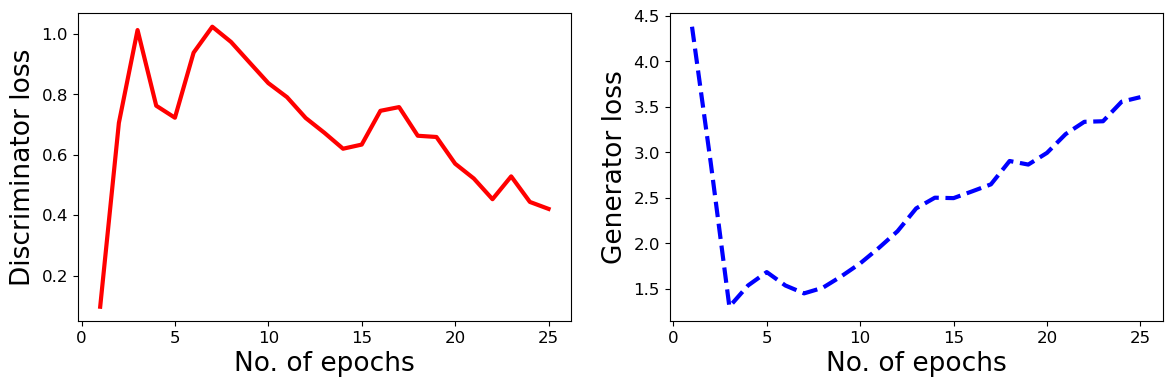

In [19]:
N = np.arange(n_epochs) + 1

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(N, discriminator_loss, 'r-', linewidth=3)
plt.xlabel('No. of epochs', fontsize=19)
plt.ylabel('Discriminator loss', fontsize=19)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.subplot(1, 2, 2)
plt.plot(N, generator_loss, 'b--', linewidth=3)
plt.xlabel('No. of epochs', fontsize=19)
plt.ylabel('Generator loss', fontsize=19)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

# 15. Generate samples from noise conditioned on labels

In [20]:
generator.eval()
n = torch.randn(40, 128, 1, 1)
y = torch.LongTensor(np.random.randint(low=0, high=10, size=(40,)))
print('Generating images for:\n', y)

Generating images for:
 tensor([0, 3, 4, 1, 9, 2, 1, 7, 3, 5, 0, 0, 7, 3, 7, 2, 9, 5, 3, 9, 9, 2, 9, 6,
        6, 3, 6, 2, 2, 7, 2, 5, 5, 5, 5, 7, 7, 9, 8, 6])


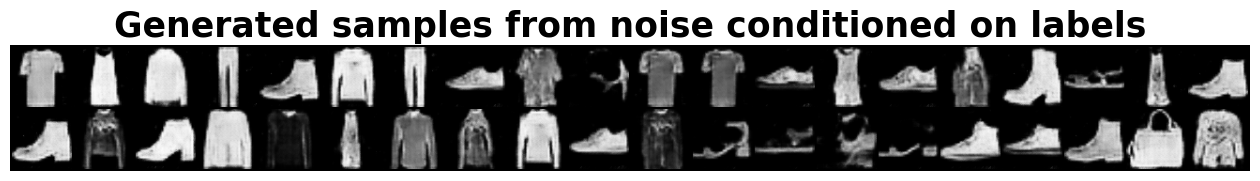

In [21]:
random_samples = generator.cpu()(n, y)
grid = make_grid(random_samples, nrow=20, normalize=True)
plt.figure(figsize=(16, 6))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.title('Generated samples from noise conditioned on labels', fontsize=25, fontweight='bold');

In [22]:
[fmnist_dataset.classes[i] for i in y]

['T-shirt/top',
 'Dress',
 'Coat',
 'Trouser',
 'Ankle boot',
 'Pullover',
 'Trouser',
 'Sneaker',
 'Dress',
 'Sandal',
 'T-shirt/top',
 'T-shirt/top',
 'Sneaker',
 'Dress',
 'Sneaker',
 'Pullover',
 'Ankle boot',
 'Sandal',
 'Dress',
 'Ankle boot',
 'Ankle boot',
 'Pullover',
 'Ankle boot',
 'Shirt',
 'Shirt',
 'Dress',
 'Shirt',
 'Pullover',
 'Pullover',
 'Sneaker',
 'Pullover',
 'Sandal',
 'Sandal',
 'Sandal',
 'Sandal',
 'Sneaker',
 'Sneaker',
 'Ankle boot',
 'Bag',
 'Shirt']